In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn.functional as F
import numpy as np
import soundfile as sf
from torch.utils.data import DataLoader
from models.model_scalar import MixingModelScalar
from models.model_scalar_v2 import MixingModelScalar2d
from data.dataset import MultitrackAudioDataset
from data.medleydb_split import train_songlist, weathervane_music, musdb18_mixed

from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

Torch version:  1.6.0
Device:  cuda


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
seed = 321
chunk_length = 1

In [4]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='train',
    seed=seed,
    normalize=True,
    compute_features=False,
    augment_data=False
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='val',
    seed=seed,
    normalize=True,
    compute_features=False,
    augment_data=False
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Train songlist: {}'.format(d_train.songlist))
print('-' * 40)
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))
print('Val songlist: {}'.format(d_val.songlist))

Train: 20 tracks, 5419 chunks
Train songlist: ['Auctioneer_OurFutureFaces', 'AvaLuna_Waterduct', 'Lushlife_ToynbeeSuite', 'Grants_PunchDrunk', 'StevenClark_Bounty', 'TheDistricts_Vermont', 'SecretMountains_HighHorse', 'StrandOfOaks_Spacestation', 'AClassicEducation_NightOwl', 'BigTroubles_Phantom', 'InvisibleFamiliars_DisturbingWildlife', 'NightPanther_Fire', 'HezekiahJones_BorrowedHeart', 'FamilyBand_Again', 'SweetLights_YouLetMeDown', 'DreamersOfTheGhetto_HeavyLove', 'HopAlong_SisterCities', 'PortStWillow_StayEven', 'Snowmine_Curfews', 'FacesOnFilm_WaitingForGa']
----------------------------------------
Val: 5 tracks, 1230 chunks
Val songlist: ['PortStWillow_StayEven', 'NightPanther_Fire', 'StevenClark_Bounty', 'HezekiahJones_BorrowedHeart', 'AClassicEducation_NightOwl']


In [5]:
train_loader = DataLoader(d_train,
                          batch_size=64,
                          shuffle=False,
                          num_workers=8,
                          pin_memory=True,
                          drop_last=False,
                          timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val,
                        batch_size=64,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True,
                        drop_last=False,
                        timeout=0,
                        worker_init_fn=None)

-1.0 -0.2617995 1.0
-1.0 -0.2617995 1.0


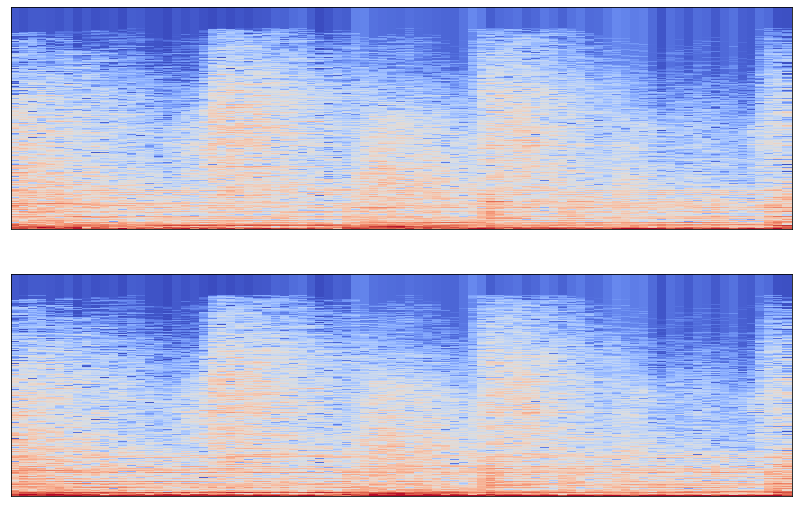

In [6]:
train_features, gt_features = d_train[50]

fig = plt.figure(figsize=(14, 9))

ax1 = plt.subplot(2,1,1)
print(np.min(gt_features), np.mean(gt_features), np.max(gt_features))
librosa.display.specshow(gt_features)

ax2 = plt.subplot(2,1,2, sharex=ax1)
norm_features = librosa.util.normalize(gt_features)
print(np.min(norm_features), np.mean(norm_features), np.max(norm_features))
librosa.display.specshow(norm_features)
plt.show()

In [6]:
model = MixingModelScalar2d().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [7]:
weights = './saved_models/scalar2d_scalar2d_2550.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [7]:
criterion = torch.nn.MSELoss(reduction='mean')
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.CosineSimilarity()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

In [8]:
metrics = {
    'mse': Loss(criterion)
}

# trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

def train_step(trainer, batch):
    model.train()
    optimizer.zero_grad()

    train_features, gt_features = batch
    masked, _ = model(train_features.to(device))

#     masked = F.normalize(masked)
#     gt_features = F.normalize(gt_features)

    loss = criterion(masked, gt_features.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def inference_step(engine, batch):
    model.eval()

    with torch.no_grad():
        train_features, gt_features = batch
        masked, _ = model(train_features.to(device))

#         masked = F.normalize(masked)
#         gt_features = F.normalize(gt_features)
        
        return masked, gt_features.to(device)

    
trainer = Engine(train_step)

# train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(train_evaluator, name)


# val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(val_evaluator, name)

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(
    patience=7,
    score_function=score_function,
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [10]:
training_history = {
    'loss': []
}
validation_history = {
    'loss': []
}
last_epoch = []


@trainer.on(Events.ITERATION_COMPLETED(every=30))
def log_training_loss():
    print("{}/{} : {} - loss: {:.5f}"
          .format(trainer.state.epoch, trainer.state.max_epochs, trainer.state.iteration, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['mse']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

In [11]:
checkpointer = ModelCheckpoint(
    './saved_models',
    'scalar2d',
    # keep all the objects
    n_saved=None,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'scalar2d': model})

In [12]:
trainer.run(train_loader, max_epochs=20)

1/20 : 30 - loss: 7.48031
1/20 : 60 - loss: 9.59257
Training Results - Epoch: 1, Avg loss: 7.30924
Validation Results - Epoch: 1, Avg loss: 7.01942
2/20 : 90 - loss: 5.82790
2/20 : 120 - loss: 3.29673
2/20 : 150 - loss: 7.34375
Training Results - Epoch: 2, Avg loss: 7.15538
Validation Results - Epoch: 2, Avg loss: 6.86885
3/20 : 180 - loss: 3.09035
3/20 : 210 - loss: 10.20226
3/20 : 240 - loss: 10.18434
Training Results - Epoch: 3, Avg loss: 13.55572
Validation Results - Epoch: 3, Avg loss: 13.82407
4/20 : 270 - loss: 1.50668
4/20 : 300 - loss: 5.82711
4/20 : 330 - loss: 3.27536
Training Results - Epoch: 4, Avg loss: 6.65315
Validation Results - Epoch: 4, Avg loss: 6.39313
5/20 : 360 - loss: 5.98551
5/20 : 390 - loss: 5.90058
5/20 : 420 - loss: 11.32084
Training Results - Epoch: 5, Avg loss: 6.55928
Validation Results - Epoch: 5, Avg loss: 6.24713
6/20 : 450 - loss: 6.38832
6/20 : 480 - loss: 6.68137
6/20 : 510 - loss: 7.15667
Training Results - Epoch: 6, Avg loss: 6.50979
Validation R

Engine run is terminating due to exception: .
Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [ ]:
trainer.run(train_loader, max_epochs=20)

In [14]:
trainer.run(train_loader, max_epochs=10)

1/10 : 30 - loss: 103.23673
1/10 : 60 - loss: 98.51045
Training Results - Epoch: 1, Avg loss: 130.57567
Validation Results - Epoch: 1, Avg loss: 106.37060
2/10 : 90 - loss: 95.21375
2/10 : 120 - loss: 120.20811
2/10 : 150 - loss: 84.27143
Training Results - Epoch: 2, Avg loss: 127.80424
Validation Results - Epoch: 2, Avg loss: 100.42713
3/10 : 180 - loss: 183.26727
3/10 : 210 - loss: 103.55842
3/10 : 240 - loss: 85.70742
Training Results - Epoch: 3, Avg loss: 125.67327
Validation Results - Epoch: 3, Avg loss: 97.47130
4/10 : 270 - loss: 162.39551
4/10 : 300 - loss: 102.32203
4/10 : 330 - loss: 98.80910
Training Results - Epoch: 4, Avg loss: 123.67210
Validation Results - Epoch: 4, Avg loss: 94.91244
5/10 : 360 - loss: 132.82137
5/10 : 390 - loss: 93.59779
5/10 : 420 - loss: 89.10655
Training Results - Epoch: 5, Avg loss: 122.18355
Validation Results - Epoch: 5, Avg loss: 92.54357
6/10 : 450 - loss: 120.20454
6/10 : 480 - loss: 85.46003
6/10 : 510 - loss: 416.90097
Training Results - Ep

State:
	iteration: 850
	epoch: 10
	epoch_length: 85
	max_epochs: 10
	output: 429.572509765625
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [17]:
trainer.run(train_loader, max_epochs=20)

11/20 : 870 - loss: 120.07035
11/20 : 900 - loss: 95.74641
11/20 : 930 - loss: 77.49526
Training Results - Epoch: 11, Avg loss: 114.66396
Validation Results - Epoch: 11, Avg loss: 84.09128
12/20 : 960 - loss: 105.99615
12/20 : 990 - loss: 78.06609
12/20 : 1020 - loss: 433.59854
Training Results - Epoch: 12, Avg loss: 113.47190
Validation Results - Epoch: 12, Avg loss: 83.42489
13/20 : 1050 - loss: 62.20241
13/20 : 1080 - loss: 99.03397
Training Results - Epoch: 13, Avg loss: 114.26889
Validation Results - Epoch: 13, Avg loss: 82.82676
14/20 : 1110 - loss: 72.95720
14/20 : 1140 - loss: 93.96223
14/20 : 1170 - loss: 80.36163
Training Results - Epoch: 14, Avg loss: 113.15216
Validation Results - Epoch: 14, Avg loss: 82.36307
15/20 : 1200 - loss: 193.08797
15/20 : 1230 - loss: 75.22365
15/20 : 1260 - loss: 66.15085
Training Results - Epoch: 15, Avg loss: 112.16090
Validation Results - Epoch: 15, Avg loss: 81.64431
16/20 : 1290 - loss: 149.84602
16/20 : 1320 - loss: 92.36343
16/20 : 1350 - 

State:
	iteration: 1700
	epoch: 20
	epoch_length: 85
	max_epochs: 20
	output: 434.1947937011719
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

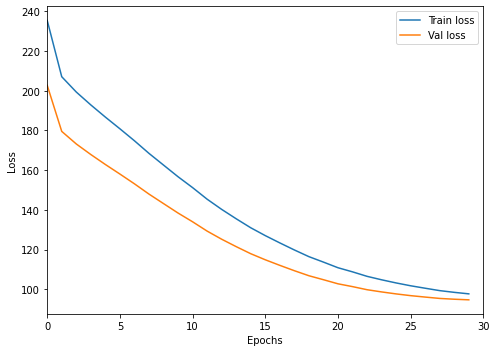

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(training_history['loss'], label='Train loss')
plt.plot(validation_history['loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))